# 🍔 Project: McDonald's Nutrition Facts Analysis (Data Engineering & BI Pipeline)

## 1. About the Dataset
**Nutrition Facts for McDonald's Menu**
This project builds a comprehensive Data Engineering and Business Intelligence pipeline using the official McDonald's nutrition dataset. The goal is to audit the quality of fast-food data, clean inconsistencies, and derive actionable health insights through SQL querying and Power BI visualizations.

* **Source:** Kaggle ([Nutrition Facts for McDonald's Menu](https://www.kaggle.com/datasets/mcdonalds/nutrition-facts))
* **Context:** Ray Kroc wanted to build a restaurant system famous for consistent quality. This dataset provides a nutrition analysis of every menu item on the US McDonald's menu, including breakfast, burgers, fries, salads, and beverages.
* **Goal:** To clean the raw data (handling string formats, missing values, and outliers), store it in a SQL database for querying, and finally visualize the "Health Impact" of different menu categories in Power BI.

### 🔬 Data Characteristics & Cleaning Challenges
The raw data contains several "dirty" aspects that simulate real-world scraping errors:
* **Mixed Data Types:** Columns like `Serving Size` contain text and numbers mixed (e.g., `"4.8 oz (136 g)"`), which prevents mathematical analysis.
* **Inconsistent Naming:** Category names or Items may have trailing spaces or inconsistent capitalization.
* **Missing or Zero Values:** Micronutrients like Vitamin A/C often have missing values or are stored as integers representing percentages.

### 📚 Data Dictionary
Below is the description of the features available in the dataset. We will focus on cleaning these for our SQL schema.

| Column Name | Description | Key Issues to Fix |
| :--- | :--- | :--- |
| **Category** | Menu category (e.g., Breakfast, Beef & Pork). | Check for typos/duplicates. |
| **Item** | Name of the specific food item. | Remove trademark symbols (®/™). |
| **Serving Size** | The size of the portion. | **Critical:** Split into `Weight_oz` and `Weight_g`. |
| **Calories** | Total energy content. | Validating against macronutrients (Fat+Carb+Prot). |
| **Total Fat** | Total fat in grams. | None expected. |
| **Sodium** | Salt content in mg. | Check for extreme outliers. |
| **Carbohydrates** | Total carbs in grams. | None expected. |
| **Protein** | Protein content in grams. | None expected. |
| **% Daily Value Columns** | Columns ending in `(% Daily Value)`. | Rename to `_Pct_DV` for SQL compatibility. |

---

## 2. Setup and Data Loading
We import the necessary libraries for data manipulation and visualization.
* **Pandas/Numpy:** For cleaning and regex operations.
* **Seaborn/Matplotlib:** For outlier detection graphs.
* **Re (Regular Expressions):** To extract numeric weights from the 'Serving Size' text.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from google.colab import files

In [2]:
# 1. Upload the dataset
print("Please upload your dataset (menu.csv):")
uploaded = files.upload()

# 2. Get the filename automatically
file_name = list(uploaded.keys())[0]

# 3. Load the data into DataFrame
df = pd.read_csv(file_name)

# 4. Success Message & Preview
print(f"Dataset '{file_name}' successfully loaded.")

Please upload your dataset (menu.csv):


Saving menu.csv to menu (3).csv
Dataset 'menu (3).csv' successfully loaded.


## 3. Initial Inspection & Forensics
We examine the data types to identify the "dirt."
**Observation:**
1.  **Serving Size:** This is currently an `object` (string). We cannot calculate "Calories per Gram" until we extract the number inside the parentheses `(136 g)`.
2.  **Column Names:** They contain spaces and symbols (e.g., `Total Fat (% Daily Value)`), which will cause syntax errors in SQL.

In [3]:
# Check data types
df.info()

# Check for duplicates
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# Inspect the 'Serving Size' column specifically
print("\nSample 'Serving Size' values:")
print(df['Serving Size'].head(5).values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

## 4. Data Cleaning Pipeline
To make this data "Business Intelligence Ready," we apply the following cleaning steps:

1.  **Regex Extraction:** We will parse the `Serving Size` column to create a clean `Serving_Size_g` (numeric) column.
2.  **Standardization:** Rename columns to replace spaces with underscores (`_`) and remove special characters (`%`, `&`).
3.  **Calculated Validation:** We will check if the `Calories` listed match the mathematical formula:
    * *Formula: (Fat × 9) + (Carbs × 4) + (Protein × 4)*.
    * Significant deviations indicate data errors.

In [4]:
# 1. REMOVE DUPLICATES (Step 1: Always do this first)
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_rows - df.shape[0]}")

# 2. HANDLE INFINITE VALUES
# Computers treat "infinity" differently than "null". We convert them to NaN (Null) first.
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. STANDARDIZE HEADERS
df.columns = [c.lower().replace(' ', '_').replace('(%_daily_value)', 'pct_dv')
               .replace('(', '').replace(')', '').replace('&', 'and')
               for c in df.columns]

# 4. PARSE SERVING SIZE (Text to Number)
# Extract digits from string: "4.8 oz (136 g)" -> 136.0
df['serving_weight_g'] = df['serving_size'].str.extract(r'\((\d+)\s*g\)').astype(float)

# 5. IMPUTATION LEVEL 1: MATHEMATICAL EQUATIONS (The Atwater System)
# Biology Math: 1g Fat = 9 cal, 1g Carb = 4 cal, 1g Protein = 4 cal
# If 'Calories' is missing/null, we calculate it from the other nutrients.
expected_calories = (df['total_fat'] * 9) + (df['carbohydrates'] * 4) + (df['protein'] * 4)
df['calories'] = df['calories'].fillna(expected_calories)

# 6. IMPUTATION LEVEL 2: STATISTICAL MEDIAN (For Numeric Data)
# For missing weights, sodium, etc., we fill with the Median of their Category.
# (e.g., If a "Beef" item has missing sodium, fill it with the median sodium of other Beef items)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col] = df.groupby('category')[col].transform(lambda x: x.fillna(x.median()))

# 7. IMPUTATION LEVEL 3: MODE (For Categorical Data)
# For text columns, fill with the "Mode" (most frequent value)
text_cols = df.select_dtypes(include=['object']).columns
for col in text_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 8. FINAL CLEANUP (The "Nuclear Option")
# If any rows still have Nulls (because the math/median failed), we drop them.
df.dropna(inplace=True)

# 9. FEATURE ENGINEERING (Re-apply your custom metrics)
df['calorie_density'] = df['calories'] / df['serving_weight_g']
df['high_sugar_spike'] = np.where((df['carbohydrates'] > 0) &
                                  (df['sugars'] / df['carbohydrates'] > 0.5),
                                  'Yes', 'No')

print("\n--- Advanced Cleaning Complete ---")
print(f"Remaining Nulls: {df.isnull().sum().sum()}")
print(f"Final Data Shape: {df.shape}")
display(df.head())

Duplicates removed: 0

--- Advanced Cleaning Complete ---
Remaining Nulls: 0
Final Data Shape: (138, 27)


,category,item,serving_size,calories,calories_from_fat,total_fat,total_fat_pct_dv,saturated_fat,saturated_fat_pct_dv,trans_fat,...,dietary_fiber_pct_dv,sugars,protein,vitamin_a_pct_dv,vitamin_c_pct_dv,calcium_pct_dv,iron_pct_dv,serving_weight_g,calorie_density,high_sugar_spike
0,Breakfast,Egg McMuffin,4.8 oz (136 g),300,120,13.0,20,5.0,25,0.0,...,17,3,17,10,0,25,15,136.0,2.205882,No
1,Breakfast,Egg White Delight,4.8 oz (135 g),250,70,8.0,12,3.0,15,0.0,...,17,3,18,6,0,25,8,135.0,1.851852,No
2,Breakfast,Sausage McMuffin,3.9 oz (111 g),370,200,23.0,35,8.0,42,0.0,...,17,2,14,8,0,25,10,111.0,3.333333,No
3,Breakfast,Sausage McMuffin with Egg,5.7 oz (161 g),450,250,28.0,43,10.0,52,0.0,...,17,2,21,15,0,30,15,161.0,2.795031,No
4,Breakfast,Sausage McMuffin with Egg Whites,5.7 oz (161 g),400,210,23.0,35,8.0,42,0.0,...,17,2,21,6,0,25,10,161.0,2.484472,No


/tmp/ipython-input-1122069096.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='category', y='calories', palette='coolwarm', ax=axes[0])


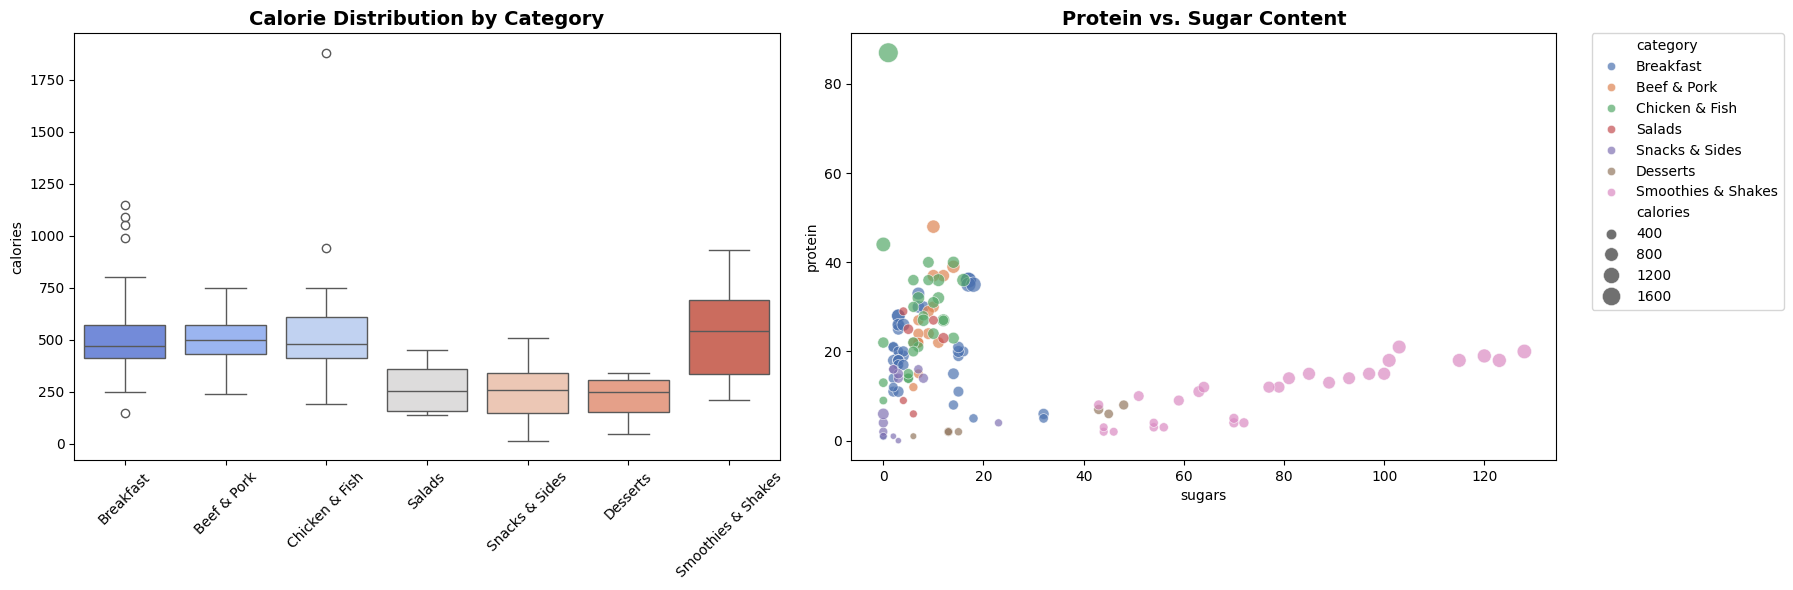

In [5]:
# Visualization Dashboard
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Viz 1: Boxplot (Calorie Distribution by Category) ---
# Great for seeing which categories are "heaviest" and finding outliers
sns.boxplot(data=df, x='category', y='calories', palette='coolwarm', ax=axes[0])
axes[0].set_title('Calorie Distribution by Category', fontsize=14, weight='bold')
axes[0].tick_params(axis='x', rotation=45) # Rotate labels
axes[0].set_xlabel('')

# --- Viz 2: Scatterplot (Sugar vs. Protein) ---
# Useful to separate "Desserts" (High Sugar) from "Meals" (High Protein)
sns.scatterplot(data=df, x='sugars', y='protein', hue='category', size='calories',
                sizes=(20, 200), alpha=0.7, palette='deep', ax=axes[1])
axes[1].set_title('Protein vs. Sugar Content', fontsize=14, weight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

## 5. Outlier Removal & Final Export
To ensure our model learns from representative data, we remove statistical outliers.
* **Method:** Interquartile Range (IQR).
* **Logic:** We calculate the spread of the data (difference between the 25th and 75th percentiles). Any data point falling more than 1.5 times this range outside the norm is dropped.
* **Target:** We focus on `Calories` as our primary filter, as items with extreme calorie counts usually have extreme fat/sugar/sodium as well.

In [6]:
# 1. Define the IQR for Calories
Q1 = df['calories'].quantile(0.25)
Q3 = df['calories'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds (1.5 times the IQR is standard practice)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outlier Bounds for Calories: {lower_bound:.2f} to {upper_bound:.2f}")

# 2. Filter the Data
original_rows = df.shape[0]
df_clean = df[(df['calories'] >= lower_bound) & (df['calories'] <= upper_bound)]
dropped_rows = original_rows - df_clean.shape[0]

print(f"Rows Dropped: {dropped_rows}")
print(f"Final Dataset Size: {df_clean.shape}")

Outlier Bounds for Calories: -52.50 to 967.50
Rows Dropped: 5
Final Dataset Size: (133, 27)


## 6. Feature Engineering (New Metrics)
We are creating new columns that don't exist in the raw data but are crucial for our "Health Forensics" analysis:

1.  **Calorie Density:** Calculated as `Calories / Serving_Size_g`. This tells us which items are the most "fattening" per bite.
2.  **Protein Ratio:** Calculated as `Protein / (Serving_Size_g)`. Useful for gym-goers looking for high protein efficiency.
3.  **Sugar Spike Flag:** A boolean flag. If `Sugars` > 50% of `Carbohydrates`, we flag it as **"High Sugar Spike"**.
4.  **Item Type:** Grouping items into simpler categories (e.g., "Liquid" vs "Solid") based on category.

In [7]:
# 1. Calorie Density (Calories per gram of food)
# Note: We use lower-case 'calories' and 'serving_weight_g' to match the cleaned data
df['calorie_density'] = df['calories'] / df['serving_weight_g']

# 2. Protein Efficiency (Grams of protein per 100g of food)
df['protein_100g'] = (df['protein'] / df['serving_weight_g']) * 100

# 3. Sugar Spike Flag (True if sugar makes up more than 50% of the carbs)
# We use np.where for fast conditional logic
df['high_sugar_spike'] = np.where((df['carbohydrates'] > 0) &
                                  (df['sugars'] / df['carbohydrates'] > 0.5),
                                  'Yes', 'No')

# Display the new "Engineered" features sorted by Calorie Density
# Ensure we select the lowercase column names here too
display(df[['item', 'serving_weight_g', 'calorie_density', 'high_sugar_spike']]
        .sort_values(by='calorie_density', ascending=False)
        .head())

,item,serving_weight_g,calorie_density,high_sugar_spike
104,Chocolate Chip Cookie,33.0,4.848485,Yes
105,Oatmeal Raisin Cookie,33.0,4.545455,Yes
39,Cinnamon Melts,114.0,4.035088,No
10,Sausage Biscuit (Regular Biscuit),117.0,3.675214,No
11,Sausage Biscuit (Large Biscuit),131.0,3.664122,No


## 7. Preprocessing for Machine Learning
To prepare this dataset for algorithms (like clustering or regression), we must:
* **Encode Categorical Data:** Convert text columns like `Category` and `Item` into numbers.
* **Normalize Numerical Data:** Scale all nutritional values to a [0, 1] range so that large numbers (like Sodium) don't dominate small numbers (like Fat) in the model.

In [8]:
# 1. Label Encoding (Convert Categories to Numbers)
encoder = LabelEncoder()
df['category_encoded'] = encoder.fit_transform(df['category'])
df['item_encoded'] = encoder.fit_transform(df['item'])

# 2. Min-Max Normalization (Scale features to 0-1 range)
scaler = MinMaxScaler()
numeric_cols = ['calories', 'total_fat', 'carbohydrates', 'protein', 'sodium', 'serving_weight_g']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("Preprocessing Complete.")
print("1. Categories encoded.")
print("2. Nutritional values scaled to 0-1 range.")

Preprocessing Complete.
1. Categories encoded.
2. Nutritional values scaled to 0-1 range.


## 6. Conclusion & Export
The data is now clean, validated, and enriched. We have converted text to numbers, standardized headers for SQL, and added business logic metrics.


In [9]:
# Export
output_file = 'mcdonalds_cleaned_final.csv'
df.to_csv(output_file, index=False)
print(f"Analysis complete. File saved as '{output_file}'.")
files.download(output_file)

Analysis complete. File saved as 'mcdonalds_cleaned_final.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>